In [127]:
%load_ext autoreload
%autoreload 2

# standard
import sys
import os

# env specific
import numpy as np
import scipy.linalg as linalg
import cv2

import matplotlib.pyplot as plt
from matplotlib import rcParams

# custom
sys.path.append('e:\\Dropbox\\py_projects\\signal\\signal')
# print(sys.path)
import src.signallib as sl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
titlefont = 'Gill Sans MT'
mainfont = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [mainfont, titlefont]

rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Data Partition
---

The data for this analysis are the cropped images from [The Extended Yale Face Database B](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html).

The data is split into a train, validation, and test sets. In this dataset, there are multiple lighting conditions and poses for 38 human subjects. 

The train/valid/test sets all contain images from every subject. Which images of a given subject are randomized into the train/valid/test sets. 

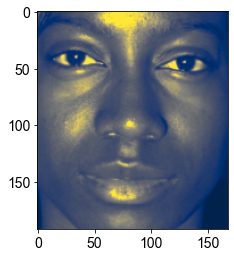

In [131]:
face = 'yaleB22'
image_filepath = f'E:/CroppedYale/{face}/'
image_filename = f'{face}_P00_Ambient.pgm'
image_filename = f'{face}_P00A+005E-10.pgm'

img_test = cv2.imread( image_filepath+image_filename, -1)

plt.imshow(img_test, cmap='cividis')

In [140]:
type(img_test[1,1])

numpy.uint8

In [437]:
image_filepath = f'E:/CroppedYale/'
# each folder contains images for one model
image_keys = [ s[-2:] for s in os.listdir(image_filepath) ]
# all folders have this prefix
image_key_filepath_prefix = 'yaleB'

# init RNG
rng = np.random.default_rng(seed=7)
# init train, valid, test file names lists
train_fns = {}
valid_fns = {}
test_fns = {}
# how many images in validation and test sets per model
nvalid_per_key = 2
ntest_per_key = 1

# create lists of filenames for each set
for k in image_keys:
   # fns in model folder
   fns = os.listdir(image_filepath+image_key_filepath_prefix+k)
   # ambient is sometimes not useful, discard non-PGM files
   fns = [fn for fn in fns if ('.pgm' in fn)&('Ambient' not in fn)]
   
   nfns = len(fns)
   # shuffle the image names
   fns_permute = rng.choice(nfns, nfns, replace=False)

   # select image names for each data set
   train_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[:-(nvalid_per_key+ntest_per_key)]
               ]
   valid_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i
                  in fns_permute[-(nvalid_per_key+ntest_per_key):-ntest_per_key] 
               ]
   test_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[-ntest_per_key:]
               ]
    

## Load and Reshape Training Data
---

1. Load each image in the training set. 
2. Reshape the 2D images into a column vector. 
3. Subtract the average image of the training set from the image.


In [354]:
def load_img_vector( filepath, meanvec=None ):
    img = cv2.imread( filepath, flags=cv2.IMREAD_GRAYSCALE)
    imgvec = np.reshape(img, (-1, ))
    if meanvec is not None:
        imgvec = imgvec - meanvec
    return imgvec

# base path to images
image_filepath = f'E:/CroppedYale/'

# rows and columns of the images
NROWS = 192
NCOLS = 168
# number of training images
NTRAIN = len(train_fns)*len(train_fns['01'])

# init X matrix
train_X = np.zeros([NROWS*NCOLS, NTRAIN], dtype=np.uint8)
i = 0
for key, fns in train_fns.items():
    for fn in fns:
        imgvec = load_img_vector( image_filepath+fn )
        train_X[:,i] = imgvec
        i += 1

train_X_mean = train_X.mean(axis=1, keepdims=True)
train_meanvec = np.reshape(train_X_mean, (-1,)) # reshape
train_X_std = train_X.std(axis=1, keepdims=True)

train_X_meansub = (train_X - train_X_mean) 
train_X_norm = (train_X - train_X_mean) / train_X_std

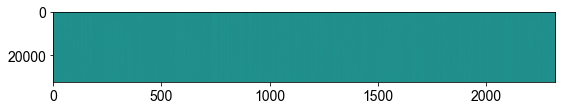

In [337]:
fig,ax = plt.subplots(figsize=(9,12))
ax.imshow(train_X_norm, aspect=0.01, vmin=-128, vmax=128)

In [305]:
train_X.max()
# train_X_meansub.min()

255

## SVD
---

Perform SVD on the training set of images. 

In [338]:
# umat, svals, vmat = linalg.svd( train_X, full_matrices=False, check_finite=False)
umat, svals, vmat = linalg.svd( train_X_meansub, full_matrices=False, check_finite=False)
# umat, svals, vmat = linalg.svd( train_X_norm, full_matrices=False, check_finite=False)

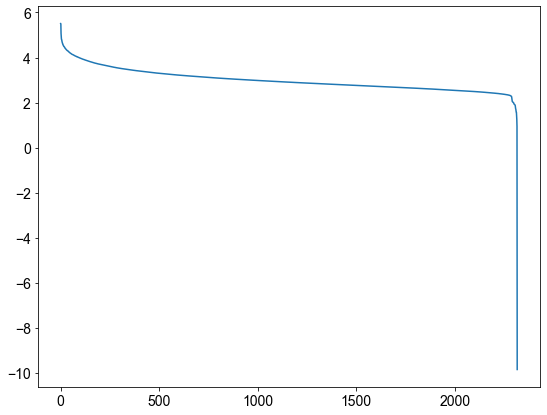

In [339]:
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(np.log10(svals))

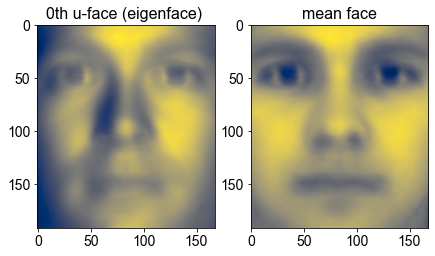

In [340]:
nu = 0
img_uface = np.reshape(umat[:,nu], [NROWS, NCOLS])
img_meanface = np.reshape(train_X_mean, [NROWS, NCOLS])
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(7,7))
cmapname = 'cividis'
ax0.imshow(img_uface, cmap=cmapname)
ax1.imshow(img_meanface, cmap=cmapname)
ax0.set_title(f'{nu}th u-face (eigenface) ')
ax1.set_title(f'mean face')
plt.show()

## Project onto u-space
---

1. For each subject, project their images onto the reduced vector space spanned by the first N columns of the U matrix.
2. Compute the average u-space projection for each subject.



In [385]:
# number of SVD vectors in dimension reduced U-space
N_UVEC = 1000
umat_reduced = umat[:, :N_UVEC]

key_projections = {}

for key, fns in train_fns.items():
    # cols are projections of fn onto u-vectors
    uproj = np.zeros([ N_UVEC, len(fns)])

    for i,fn in enumerate(fns):
        imgvec = load_img_vector(image_filepath+fn, meanvec=train_meanvec)
        
        uproj_fn = np.transpose(umat_reduced) @ imgvec

        uproj[:,i] = uproj_fn
    
    key_projections[key] = uproj


In [386]:
imgvec.shape

(32256,)

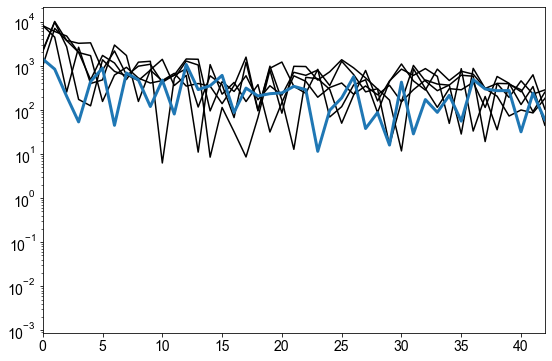

In [415]:
keytemp = '01'
fig,ax = plt.subplots(figsize=(9,6))
nimg = key_projections[keytemp].shape[1]

umean = np.median(key_projections[keytemp], axis=1)
ax.semilogy(np.abs(umean), linewidth=3, zorder=1)
for i in range(5):
    ax.semilogy(np.abs(key_projections[keytemp][:,i]), color='k', linewidth=1.5, zorder=0)
ax.set_xlim([0,42])
# ax.set_ylim([-1000,1000])
plt.show()

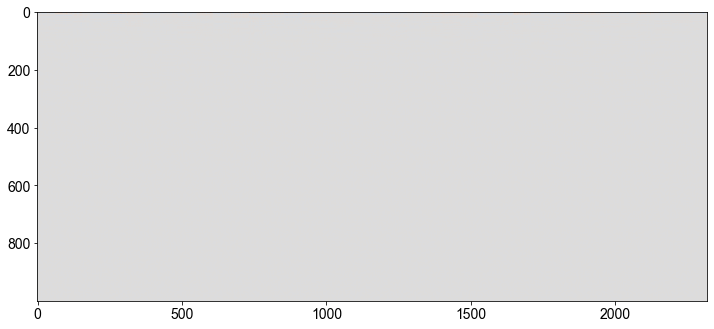

In [393]:
fig,ax = plt.subplots(figsize=(12,12))
train_projection = np.transpose(umat_reduced) @ train_X_meansub
# plt.imshow(train_projection[:22,:64], aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)
plt.imshow(train_projection, aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)

In [404]:
# average projection of key onto u-space
NKEYS = len(image_keys)
key_projections_u_mean = np.zeros([NKEYS, N_UVEC])
key_projections_u_median = np.zeros([NKEYS, N_UVEC])
for i,(key,proj) in enumerate(key_projections.items()):
    # print(i)
    key_projections_u_mean[i,:] = proj.mean(axis=1)
    key_projections_u_median[i,:] = np.median(proj, axis=1)

    

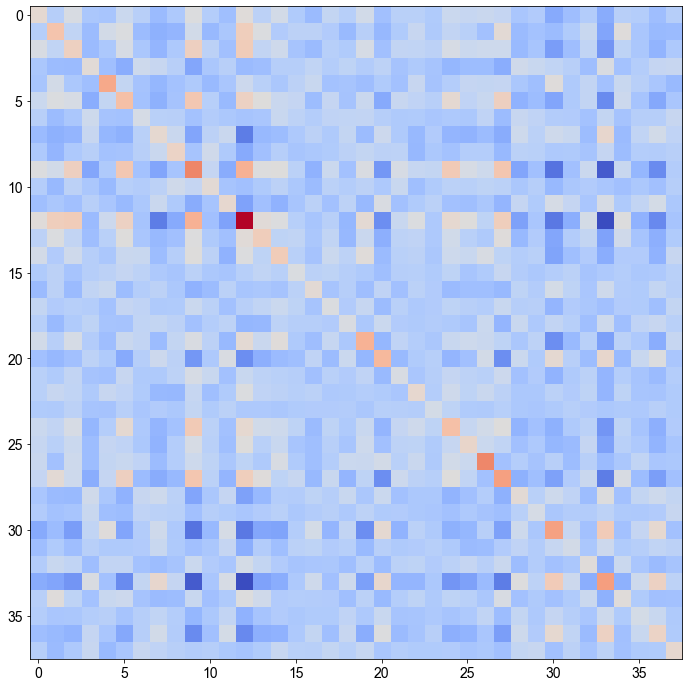

In [405]:
fig,ax = plt.subplots(figsize=(12,12))

# plt.imshow(key_projections_u_mean @ np.transpose(key_projections_u_mean) , aspect=1, cmap='coolwarm',  interpolation='none')
plt.imshow(key_projections_u_median @ np.transpose(key_projections_u_median) , aspect=1, cmap='coolwarm',  interpolation='none')
# plt.imshow(np.transpose(key_projections_u_mean[:,:]), aspect=1, cmap='coolwarm', vmin=-5e3,vmax=5e3, interpolation='none')

## Classify Image
---

Attempt to classify an image (which subject is it?) based on its projection on the u-space. 
1. Load image, $\vec{y}$
2. Project onto reduced u-space, $U^T\vec{y}$
3. Matrix of average u-space projection, $V$
4. Compute correlation with subject classes: $V U^T\vec{y}$ 




In [406]:
def softmax( zvec ):
    """
    Boltzman distribution for the values of the zvec.
    """
    Z = np.sum(np.exp(zvec))
    return np.exp(zvec) / Z

def img_class_prob( imgvec, umat_reduced, key_project_mean ):

    imgvec_proj = np.transpose(umat_reduced) @ imgvec
    normconst_imgvec_proj = np.sqrt(imgvec_proj @ imgvec_proj)
    normconstvec_key_proj = (key_project_mean @ np.transpose(key_project_mean)).diagonal()
    normconstvec_key_proj = np.sqrt(normconstvec_key_proj)
    # print(normconstvec_key_proj)
    imgvec_proj_overlap = (key_project_mean @ imgvec_proj)  / (normconstvec_key_proj * normconst_imgvec_proj)
    # imgvec_probability = imgvec_proj_overlap
    imgvec_probability = softmax( imgvec_proj_overlap )
    return imgvec_probability



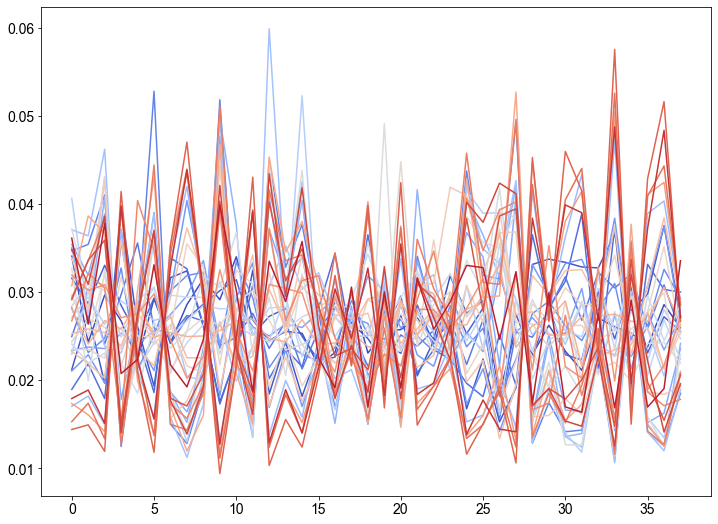

In [427]:
fig, ax = plt.subplots(figsize=(12,9))
from matplotlib import cm
cmap = cm.get_cmap('coolwarm')
for i,keytemp in enumerate(image_keys):
    fnindextemp = 3
    imgvec1 = load_img_vector(image_filepath+train_fns[keytemp][fnindextemp], meanvec=train_meanvec)
    img_prob = img_class_prob( imgvec1, umat_reduced, key_projections_u_mean )
    # print(img_prob)
    # print(img_prob.sum())
    ax.plot(img_prob, linewidth=1.5, color=cmap((i)/NKEYS))

(-1000.0, 1000.0)

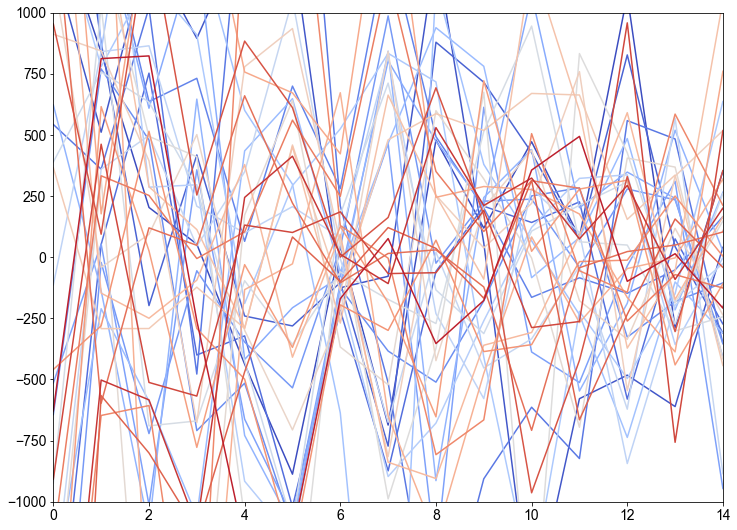

In [435]:
fig, ax = plt.subplots(figsize=(12,9))
from matplotlib import cm
cmap = cm.get_cmap('coolwarm')
for i,keytemp in enumerate(image_keys):
    ax.plot(key_projections_u_median[i,:], linewidth=1.5, color=cmap((i)/NKEYS))

ax.set_xlim([0,14])
ax.set_ylim([-1e3,1e3])

In [429]:
key_projections_u_median.shape

(38, 1000)